
## MERFISH and scRNA data integration

We apply uniPort to integrate high-plex RNA imaging-based spatially resolved MERFISH data with scRNA-seq data. The MERFISH data includes 64,373 cells with 155 genes, and the scRNA-seq data includes 30,370 cells with 21,030 genes from six mice measured with dissociated scRNA-seq (10X).

In [1]:
import uniport as up
import scanpy as sc
import pandas as pd
import numpy as np
up.__version__

'1.1.1'

Read the cell type annotations of MERFISH and scRNA-seq data seperately.

In [2]:
labels_merfish = pd.read_csv('MERFISH/MERFISH_st_filter_cluster.txt', sep='\t')
celltype_merfish = labels_merfish['cluster_main'].values
labels_rna = pd.read_csv('MERFISH/MERFISH_scRNA_filter_cluster.txt', sep='\t')
celltype_rna = labels_rna['cluster_main'].values

Read MERFISH and scRNA-seq into `AnnData` objects using `load_file` fucntion in uniport.   

In [3]:
# adata_merfish = sc.read_h5ad('MERFISH/merfish0.h5ad')
# adata_rna = sc.read_h5ad('MERFISH/rna0.h5ad')
adata_merfish = up.load_file('MERFISH/MERFISH_mouse1.txt')
adata_rna = up.load_file('MERFISH/RNA_count.txt')

Add 'cell_type', 'domain_id' and 'source' to the `AnnData`objects.\
'cell_type' stores cell label annotations. \
'domain_id' identifies the modality using a number category. \
'source' identifies the modality using its name.

In [4]:
adata_merfish.obs['cell_type'] = celltype_merfish
adata_merfish.obs['domain_id'] = 0
adata_merfish.obs['domain_id'] = adata_merfish.obs['domain_id'].astype('category')
adata_merfish.obs['source'] = 'MERFISH'

adata_rna.obs['cell_type'] = celltype_rna
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

print(adata_rna.obs)
print(adata_merfish.obs)

                     cell_type domain_id source
AAACCTGAGATGTGGC-1  Fibroblast         1    RNA
AAACCTGCACACAGAG-1  Excitatory         1    RNA
AAACCTGCACTACAGT-1  Inhibitory         1    RNA
AAACCTGTCAGGATCT-1  Excitatory         1    RNA
AAACCTGTCGCACTCT-1   OD Mature         1    RNA
...                        ...       ...    ...
TTTGGTTGTTATCACG-6  Inhibitory         1    RNA
TTTGGTTGTTATTCTC-6  Inhibitory         1    RNA
TTTGTCAGTTCCGTCT-6  Inhibitory         1    RNA
TTTGTCATCGTGGGAA-6  Inhibitory         1    RNA
TTTGTCATCTTTACAC-6  Excitatory         1    RNA

[30370 rows x 3 columns]
             cell_type domain_id   source
cell1        Astrocyte         0  MERFISH
cell2       Inhibitory         0  MERFISH
cell3       Inhibitory         0  MERFISH
cell4       Inhibitory         0  MERFISH
cell5       Inhibitory         0  MERFISH
...                ...       ...      ...
cell73650    OD Mature         0  MERFISH
cell73651    OD Mature         0  MERFISH
cell73653  OD Immatu

Concatenate scATAC-seq and scRNA-seq with common genes using `AnnData.concatenate`.

In [5]:
adata_cm = adata_merfish.concatenate(adata_rna, join='inner', batch_key='domain_id')
print(adata_cm.obs)

                       cell_type domain_id   source
cell1-0                Astrocyte         0  MERFISH
cell2-0               Inhibitory         0  MERFISH
cell3-0               Inhibitory         0  MERFISH
cell4-0               Inhibitory         0  MERFISH
cell5-0               Inhibitory         0  MERFISH
...                          ...       ...      ...
TTTGGTTGTTATCACG-6-1  Inhibitory         1      RNA
TTTGGTTGTTATTCTC-6-1  Inhibitory         1      RNA
TTTGTCAGTTCCGTCT-6-1  Inhibitory         1      RNA
TTTGTCATCGTGGGAA-6-1  Inhibitory         1      RNA
TTTGTCATCTTTACAC-6-1  Excitatory         1      RNA

[94743 rows x 3 columns]


Preprocess data using functions `normalize_total`, `log1p` and `highly_variable_genes` in `scanpy` and `batch_scale` in uniport (modified from [SCALEX](https://scalex.readthedocs.io/en/latest/api/index.html#preprocessing))

In [6]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
up.batch_scale(adata_cm)

... storing 'cell_type' as categorical
... storing 'source' as categorical


In [7]:
sc.pp.normalize_total(adata_merfish)
sc.pp.log1p(adata_merfish)
sc.pp.highly_variable_genes(adata_merfish, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_merfish)

In [8]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_rna)

Save the preprocessed data for integration online prediction.

In [9]:
adata_merfish.write('MERFISH/MERFISH_processed.h5ad', compression='gzip')
adata_rna.write('MERFISH/RNA_processed.h5ad', compression='gzip')
adata_cm.write('MERFISH/MERFISH_and_RNA.h5ad', compression='gzip')

... storing 'cell_type' as categorical
... storing 'source' as categorical
... storing 'cell_type' as categorical
... storing 'source' as categorical


Visualize the data using UMAP according to their cell types and sources.

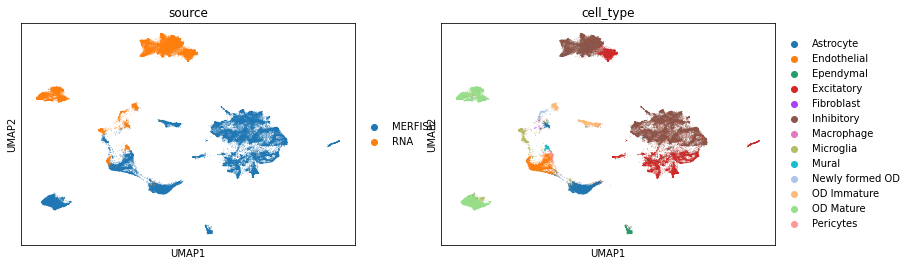

In [10]:
adata_cm_copy = adata_cm.copy()
sc.pp.pca(adata_cm_copy)
sc.pp.neighbors(adata_cm_copy)
sc.tl.umap(adata_cm_copy, min_dist=0.1)
sc.pl.umap(adata_cm_copy, color=['source', 'cell_type'])

Integrate the MERFISH and scRNA-seq data using both common and dataset-specific genes by *Run()* function in uniport. The latent representations of data are stored in `adata.obs['latent']`.

In [11]:
adata = up.Run(adatas=[adata_merfish, adata_rna], adata_cm=adata_cm, lambda_kl=5.0)

Dataset 0: MERFISH
AnnData object with n_obs × n_vars = 64373 × 155
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 30370 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 94743 × 153
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'




Epochs: 100%|████████████████████████████████████| 82/82 [19:21<00:00, 14.16s/it, recloss=795.64,klloss=29.19,otloss=4.08]


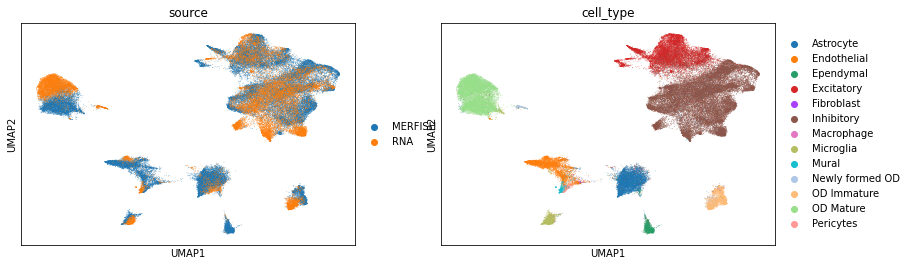

In [12]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])